In [782]:
import numpy as np
import random
from scipy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
import math

In [1002]:
class HMM:
    
    def __init__(self, A, E, outputs):
        self.A = A
        self.E = E
        self.outputs = outputs
        outdic = {}
        for i in range(0, len(outputs)):
            key = outputs[i]
            outdic[key] = i
        self.outdic = outdic
        self.nodes = len(A[0])
        self.pi = self.stable_pi()
        
        self.lastA = np.copy(A)
        self.lastE = np.copy(E)

    def stable_pi(self):
        w, vl, vr = eig(A, left=True)
        pi = None
        for j in range(0, vl.shape[1]):
            if all (x > 0 for x in vl[:, j]) or all (x < 0 for x in vl[:, j]):
                pi = vl.real[:,j]/sum(vl.real[:,j])
                self.pi = pi
                return pi
        if type(pi) is type(None):
            print("Issue with eigenvalues; manually select which column (starting at 0)")
            print(vl)
            col = int(input())
            pi = vl.real[:,col]/sum(vl.real[:,col])
        self.pi = pi
        return pi
    
    def run(self, num_it, start = None):
        states = []
        res = []
        picurr = np.zeros(self.nodes)
        if type(start) is type(None):
            start = np.random.choice(np.arange(0, self.nodes), p=self.pi)
        picurr[start] = 1
        prev = start
        states.append(start)
        curr = 0
        for i in range(0, num_it):
            #choose which node we're moving to
            curr = np.random.choice(np.arange(0, self.nodes), p=list(np.matmul(picurr, A)))
            picurr[prev] = 0
            picurr[curr] = 1
            prev = curr
            states.append(curr)
            #choose the output
            out = np.random.choice(outputs, p=list(E[curr]))
            res.append(out)
        return res, states
        
    #probability that the HMM generated the results
    def forward_algorithm(self, res):
        results = np.array(res)
        alpha_max = len(results)
        forwardmat = np.zeros((self.nodes, alpha_max))
        #add first col
        for i in range(0, self.nodes):
            #alpha1(Xi)
            output_index = self.outdic[results[alpha_max -1]] 
            forwardmat[i, 0] = self.pi[i]*self.E[i, output_index]

        #now calculate each of the following rows
        for j in range(1, alpha_max):
            for i in range(0, self.nodes):
                s = 0
                for prevrowi in range(0, self.nodes):
                    alpha_iminus1 = forwardmat[prevrowi, j-1]
                    prob_xi_given_ximinus1 = self.A[prevrowi, i]
                    output_index = self.outdic[results[alpha_max -(j+1)]] 
                    prob_result_given_x = self.E[i, output_index]
                    s = s + alpha_iminus1*prob_xi_given_ximinus1*prob_result_given_x
                forwardmat[i, j] = s
        return forwardmat, sum(forwardmat[:, alpha_max -1])
        
    def all_combos(self, num_out):
        options = np.ndarray((len(self.outputs)**num_out, num_out), dtype = object)
        for col in range(0, num_out):
            row = 0
            while row < len(self.outputs)**num_out:
                for element in self.outputs:
                    for it in range(0, len(self.outputs)**col):
                        options[row, col] = element
                        row = row + 1
        return options
    
    def backward_algorithm(self, res):
        results = np.array(res)
        L = len(results)
        backwardmat = np.zeros((self.nodes, L+1))
        
        #setting the last row
        for i in range(0, self.nodes):
            backwardmat[i, L] = 1 
        
        t = L-1
        while t >=0:
            for i in range(0, self.nodes): #i is the state
                s = 0
                for j in range(0, self.nodes):
                    aij = self.A[i, j]
                    o_t_plus_1 = self.outdic[results[t]]
                    bjo_t_plus_1 = self.E[j, o_t_plus_1]
                    beta_t_plus_1 = backwardmat[j, t+1]
                    s = s + aij*bjo_t_plus_1*beta_t_plus_1
                backwardmat[i, t] = s
            t = t -1
        return backwardmat
    
    def zeta(self, i, j, t, res, forward, backward): #t between 0 and the len(res)
        if t < 0 or t >= len(res):
            raise Exception("t is incorrect. t must be such that: 0 <= t < len(res)")
        
        alpha_t_i = forward[i, len(res) -1 -t ] #prob of res[0:t] given tth node is i
        a_ij = self.A[i, j] #prob going from node i to j
        out_index_of_t_plus_1 = self.outdic[res[t+1]] 
        b_j_o_t_plus_1 = self.E[j, out_index_of_t_plus_1] #probability that node j outputted the t+1th output
        beta_t_plus_1_j = backward[j, len(res) -t] #probability of output[t+1:] given node t+1 is j
        sum_alpha_tj_times_beta_tj = 0
        for j_temp in range(0, self.nodes):
            sum_alpha_tj_times_beta_tj = sum_alpha_tj_times_beta_tj + (forward[j_temp, len(res) -1 -t]*backward[j_temp, len(res)-1-t])
        zeta = alpha_t_i * a_ij * b_j_o_t_plus_1 * beta_t_plus_1_j / sum_alpha_tj_times_beta_tj
        return zeta
    
    def new_a_i_j(self, i, j, res, forward, backward):
        if len(res) <= 2:
            raise ValueException("Length of res must be greater than 2 or else why are u using this equation")
        s_zeta_i_j = 0
        for t in range(0, len(res)-1):
            s_zeta_i_j = s_zeta_i_j + self.zeta(i, j, t, res, forward, backward)
        s_zeta_all_j_all_t = 0
        for t in range(0, len(res)-1):
            for node in range(0, self.nodes):
                x = self.zeta(i, node, t, res, forward, backward) 
                s_zeta_all_j_all_t = s_zeta_all_j_all_t + x
        if s_zeta_i_j/s_zeta_all_j_all_t == 0:
            return self.lastA[i, j] * .5
        return s_zeta_i_j/s_zeta_all_j_all_t
    
    def b_j_o(self, j, out, res, forward, backward):
        num = 0
        den = 0
        for t in range(0, len(res)):
            gamma_top = forward[j, len(res) - 1 -t] *backward[j, len(res) -1-t]
            gamma_denom = 0 
            for j_temp in range(0, self.nodes):
                gamma_denom = gamma_denom + (forward[j_temp, len(res) -1 -t]*backward[j_temp, len(res)-1-t])
            gamma = gamma_top/gamma_denom
            den = den + gamma
            if (type(out) is type('A') and res[t] == out) or (self.outdic[res[t]] == out):
                num = num+gamma
        if num/den == 0: #this will happen if a specific out isn't in a result
            if type(out) is type('A'):
                index = self.outdic[out]
                return self.lastE[j, index] *.5 
            else: 
                return self.lastE[j, out] *.5
                
        return num/den
    
    def train(self, res):
        backward = self.backward_algorithm(res)
        forward = self.forward_algorithm(res)[0]
        new_A = np.zeros(self.A.shape)
        new_E = np.zeros(self.E.shape)
        for i in range(0, self.nodes):
            for j in range(0, self.nodes):
                new_A[i, j] = self.new_a_i_j(i, j, res, forward, backward)
        for j in range(0, self.nodes):
            for out in self.outputs:
                out_index = self.outdic[out]
                new_E[j, out_index] = self.b_j_o(j, out_index, res, forward, backward)
        
        for i in range(0, new_A.shape[0]):
            for j in range(0, new_A.shape[1]):
                if math.isnan(new_A[i, j]):
                    print("WE'VE GOT NAN")
                    print("old A")
                    print(self.A)
                    print("old E")
                    print(self.E)
                    
                    
        new_A = self.normalize(new_A)
        new_E = self.normalize(new_E)
        distance_A = self.distance(self.A, new_A) #euclidian dist from old to new A and E
        distance_E = self.distance(self.E, new_E)
        self.lastA = np.copy(self.A)
        self.lastE = np.copy(self.E)
        
        self.A = np.copy(new_A)
        self.E = np.copy(new_E)
        self.pi = self.stable_pi()
        
        return distance_A, distance_E
    
    def distance(self, X, Y):
        dist = np.linalg.norm(X - Y)
        return dist
    
    def random_init(self):
        A_temp = np.random.rand(self.A.shape[0], self.A.shape[1])
        E_temp = np.random.rand(self.E.shape[0], self.E.shape[1])
        for i in range(0, A_temp.shape[0]):
            self.A[i] = A_temp[i]/sum(A_temp[i])
            self.E[i] = E_temp[i]/sum(E_temp[i])
        self.pi = self.stable_pi()
        
    def normalize(self, temp):
        for i in range(0, temp.shape[0]):
            temp[i] = temp[i]/sum(temp[i])
        return temp
            
        

In [505]:
"""
HMM parameters
3 hidden states
5 outputs
"""
#each ith row is the probabilities of moving to the jth node of that row given you're at the ith node
A = np.array([[0.2, 0.6, 0.2], [0.3, 0, 0.7], [0.2, 0.8, 0]]) 
#each ith row is the probability of outputting the jth output given you're at the ith node
E = np.array([[.1, 0.4, .5, 0], [.3, .5, 0, 0.2], [0.3, 0, .4, .3]])
#all possible outputs of the HMM
outputs = np.array(['A', 'C', 'T', 'G'])

In [275]:
model = HMM(A, E, outputs)
res = model.run(5)
fw, prob_res = model.forward_algorithm(res)
all_opt = model.all_combos(5)

In [998]:
model = HMM(A, E, outputs)
res = model.run(6)
res[0]

(['A', 'A', 'C', 'T', 'A', 'T'], [0, 0, 2, 0, 2, 0, 0])

In [404]:
#checking that the sum of all probabilities of all options is 1
model = HMM(A, E, outputs)
total_prob = 0
num_out = 6
results = model.all_combos(num_out)
for row in results:
    junk, prob_row = model.forward_algorithm(row)
    total_prob = total_prob + prob_row
print(total_prob)

1.000000000000002


In [403]:
#checking that the sum of all probabilities of all options is 1
model = HMM(A, E, outputs)
total_prob = np.zeros(len(A[0]))
num_out = 7
results = model.all_combos(num_out)
for row in results:
    backmat = model.backward_algorithm(row)
    total_prob = np.add(total_prob, backmat[:,0])
print(total_prob)

[1. 1. 1.]


In [591]:
model = HMM(A, E, outputs)
res, states = model.run(5)
#res = ['pine', 'pine', 'pineapple', 'penapple']
#res = ['C', 'C', 'C', 'C', 'T']
print(res)
forward, junk = model.forward_algorithm(res)
backward = model.backward_algorithm(res)
a_i_j = model.new_a_i_j(2, 2, res, forward, backward)
#print(a_i_j)

b__J = model.b_j_o(2, 3, res, forward, backward )

['T', 'G', 'T', 'A', 'T']


In [993]:
model = HMM(A, E, outputs)
model.random_init()
res, states = model.run(6)
print(res)
print(states[1:])

forward, prob_O_a = model.forward_algorithm(res)
backward = model.backward_algorithm(res)
for t in range(0, len(res)):
    f = sum(forward[:, len(res) - 1 -t]) #summing over all nodes
    s = sum(backward[:,len(res) - 1-t]) #summing over all nodes
    print("for t = %d, probability of output based on fwd/bkwd = %f" % (t, f*s))
print(prob_O_a)
prob_O_b = 0
for j in range(0, model.nodes):
    p = model.pi[j]
    bj = model.E[j, model.outdic[res[0]]]
    betaj = backward[j, 1]
    prob_O_b = prob_O_b + p*bj*betaj
print(prob_O_b)

['G', 'T', 'G', 'T', 'C', 'A']
[1, 0, 2, 0, 2, 2]
for t = 0, probability of output based on fwd/bkwd = 0.000075
for t = 1, probability of output based on fwd/bkwd = 0.000178
for t = 2, probability of output based on fwd/bkwd = 0.000184
for t = 3, probability of output based on fwd/bkwd = 0.000213
for t = 4, probability of output based on fwd/bkwd = 0.000185
for t = 5, probability of output based on fwd/bkwd = 0.000086
0.0001136236659391951
0.00011515067465915038


In [1003]:
num_runs = 200
repeats = 5

actual = HMM(A, E, outputs)
run_num = list(range(0,num_runs*repeats)) #to accomodate for starting state
A_errs = []
E_errs = []
training = HMM(A, E, outputs)
#training.random_init()
results = []
for i in range(0, num_runs):
    res, trash = actual.run(14)
    results.append(res)


for repeat in range(0, repeats):
    for i in range(0, len(results)):
        res = results[i]
        A_dis, E_dis = training.train(res)
        A_errs.append(A_dis)
        E_errs.append(E_dis)
        if A_dis + E_dis < 0.00000000000000000000001:
            break
        if A_dis > 2 or E_dis > 2:
            training.random_init()


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:126: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in double_scalars


WE'VE GOT NAN
old A
[[7.04501958e-202 1.30019144e-109 1.00000000e+000]
 [1.00000000e+000 4.92304207e-299 2.06238743e-284]
 [1.00000000e+000 2.96480942e-311 0.00000000e+000]]
old E
[[2.85714286e-001 1.42857143e-001 5.71428571e-001 2.52677102e-084]
 [1.81148389e-234 9.84304162e-058 1.00000000e+000 7.47374710e-190]
 [7.61141170e-125 3.00068338e-001 5.49897493e-001 1.50034169e-001]]
WE'VE GOT NAN
old A
[[7.04501958e-202 1.30019144e-109 1.00000000e+000]
 [1.00000000e+000 4.92304207e-299 2.06238743e-284]
 [1.00000000e+000 2.96480942e-311 0.00000000e+000]]
old E
[[2.85714286e-001 1.42857143e-001 5.71428571e-001 2.52677102e-084]
 [1.81148389e-234 9.84304162e-058 1.00000000e+000 7.47374710e-190]
 [7.61141170e-125 3.00068338e-001 5.49897493e-001 1.50034169e-001]]
WE'VE GOT NAN
old A
[[7.04501958e-202 1.30019144e-109 1.00000000e+000]
 [1.00000000e+000 4.92304207e-299 2.06238743e-284]
 [1.00000000e+000 2.96480942e-311 0.00000000e+000]]
old E
[[2.85714286e-001 1.42857143e-001 5.71428571e-001 2.5267

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan 

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT 

 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old 

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]


old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan

 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old 

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old 

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]


old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan

old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan

old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan 

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan

WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT 

old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan 

 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT 

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]


WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]

old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
WE'VE GOT NAN
old A
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
old E
[[nan nan nan nan]
 [nan nan nan

Text(0, 0.5, 'Error')

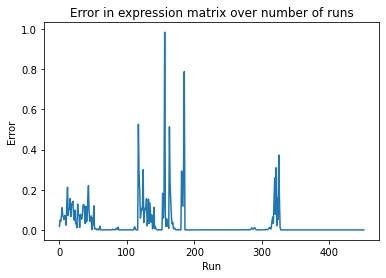

In [996]:

plt.plot(run_num, A_errs)
plt.title("Error in expression matrix over number of runs")
plt.xlabel("Run")
plt.ylabel("Error")

In [999]:
A_errs

[0.017535175887805347,
 0.04864102317040738,
 0.04270396252430674,
 0.0700762226723345,
 0.11062521116805343,
 0.06915364822196633,
 0.06610550567566183,
 0.05176946693277689,
 0.07177896287205189,
 0.061126099971182665,
 0.02380253594720636,
 0.14021665030163985,
 0.21222271068019596,
 0.07199234963327433,
 0.10355287677817514,
 0.10317910082630939,
 0.15678338762245703,
 0.06693085810825314,
 0.12709443591714353,
 0.13253530138118286,
 0.14260058930185757,
 0.07770985946744592,
 0.048534066578488626,
 0.09856397970347615,
 0.031099139829588215,
 0.03202299432278137,
 0.011424480472456238,
 0.12833160254414364,
 0.07333452060163899,
 0.07283386461786685,
 0.012305419201616789,
 0.07809535385681965,
 0.07011458797772556,
 0.05368445184761507,
 0.07544181983806815,
 0.12295059173253096,
 0.12704581333749676,
 0.11296063297353715,
 0.03251543418342757,
 0.11751720161936134,
 0.03943455201257902,
 0.04794199486590831,
 0.15068952296067953,
 0.22016721580693607,
 0.09465074654427896,
 0.04

NameError: name 'run_sum' is not defined

In [759]:
print(training_hist[1][0])
#print(actual.E[0])

[[0.39924925 0.5199801  0.08077065]
 [0.31480442 0.30391081 0.38128477]
 [0.75813591 0.21844054 0.02342355]]


In [770]:
out = 'A'
res = results[0]
print(res[1])
if res[1] == out:
    print("adssfg")
print(model.outdic[res[1]])

print(model.outdic['A'])
if model.outdic[res[1]] == 0:
    print("ues")

A
adssfg
0
0
ues


In [872]:
A = np.array([[0.22828463 ,0.42731331, 0.34440206], [0.3677956 , 0.29572231 ,0.33648208], [0.08338913, 0.45268729, 0.46392358]])

E = np.array([[0.08087098, 0.66909254, 0. ,        0.25003649], [0.27509819, 0.06405036, 0.      ,   0.66085145], [0.22445673, 0.47684807, 0.        , 0.2986952 ]])
"""
backward
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
"""

res = ['T', 'G', 'A', 'C', 'T']

test = HMM(A, E, outputs)
backward = test.backward_algorithm(res)
backward

HELLLLLLOOOOOOO WE'RE IN BACKWARD ALG
backwardmat in the function
HERE IS THE STUFF YOU NEED
self.A
[[0.22828463 0.42731331 0.34440206]
 [0.3677956  0.29572231 0.33648208]
 [0.08338913 0.45268729 0.46392358]]
self.E
[[0.08087098 0.66909254 0.         0.25003649]
 [0.27509819 0.06405036 0.         0.66085145]
 [0.22445673 0.47684807 0.         0.2986952 ]]
backward
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
res
['T', 'G', 'A', 'C', 'T']
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [1001]:
res =  ['A', 'A', 'C', 'T', 'A', 'T']
training = HMM(A, E, outputs)
training.train(res)
print(training.A)
print(training.E)
training.train(res)
print(training.A)
print(training.E)

[[0.26343376 0.01365363 0.7229126 ]
 [0.3699675  0.22574551 0.40428699]
 [0.46090829 0.07932198 0.45976973]]
[[0.4880431  0.12900126 0.32715086 0.05580479]
 [0.56201462 0.06116691 0.21293891 0.16387955]
 [0.44936607 0.19634445 0.32693725 0.02735223]]
[[0.27499982 0.01345674 0.71154344]
 [0.38386314 0.21995011 0.39618676]
 [0.47535922 0.07642757 0.44821321]]
[[0.48986139 0.12829718 0.32603664 0.05580479]
 [0.52547467 0.04955292 0.26109286 0.16387955]
 [0.46051912 0.1935779  0.31855075 0.02735223]]
